In [51]:
import pandas as pd
# from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [52]:
# Read the CSV file
#filename = 'temperature_log_12.csv'
#filename = 'temperature_logB_12.csv'
#filename = 'temperature_logC_4.csv'
filename = 'temperature_logC_2025-03-12.csv'
df = pd.read_csv(filename)
#df = pd.read_csv('temperature_log_12.csv')
# df = pd.read_csv('temperature_logB_12.csv')
#df = pd.read_csv('temperature_logC_2.csv')

# Rename the temperature columns to something simpler
df = df.rename(columns={
    'Temperature Sensor 1._temperature._tcp.local.': 'temp1',
    'Temperature Sensor 2._temperature._tcp.local.': 'temp2'
})

# Convert timestamp string to datetime
df['timestamp'] = pd.to_datetime(df['Timestamp'])

# Drop the original Timestamp column
df = df.drop('Timestamp', axis=1)

# Replace 'ERROR' with NaN (Not a Number)
df['temp1'] = pd.to_numeric(df['temp1'], errors='coerce')
df['temp2'] = pd.to_numeric(df['temp2'], errors='coerce')

# Display the first few rows and basic statistics
print("First few rows of the parsed data:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())

First few rows of the parsed data:
   temp1  temp2           timestamp
0  21.06  11.81 2025-02-13 20:42:55
1  21.19  11.75 2025-02-13 20:43:27
2  21.12  11.94 2025-02-13 20:44:00
3  21.12  11.94 2025-02-13 20:44:31
4  21.06  11.75 2025-02-13 20:45:03

Basic statistics:
              temp1         temp2                      timestamp
count  72398.000000  72917.000000                          72921
mean      19.282668     12.628557  2025-02-27 08:00:05.563884032
min       15.380000      3.810000            2025-02-13 20:42:55
25%       18.500000      9.750000            2025-02-20 16:34:24
50%       19.500000     12.380000            2025-02-27 07:58:52
75%       20.250000     15.060000            2025-03-05 23:14:39
max       21.250000     24.620000            2025-03-12 15:39:19
std        1.165554      4.047119                            NaN


In [53]:
# Get the last timestamp in the data
last_timestamp = df['timestamp'].max()
print(f"Last recorded timestamp: {last_timestamp}")


Last recorded timestamp: 2025-03-12 15:39:19


In [54]:
df.index.name

In [55]:
# Check if input file has "logC" in the name
if 'logC' in filename:
    # Filter data after the specified timestamp
    cutoff_time = pd.to_datetime('2025-02-27 19:48:04')
    df = df[df['timestamp'] >= cutoff_time]
    print(f"Filtered data to entries after {cutoff_time}")


Filtered data to entries after 2025-02-27 19:48:04


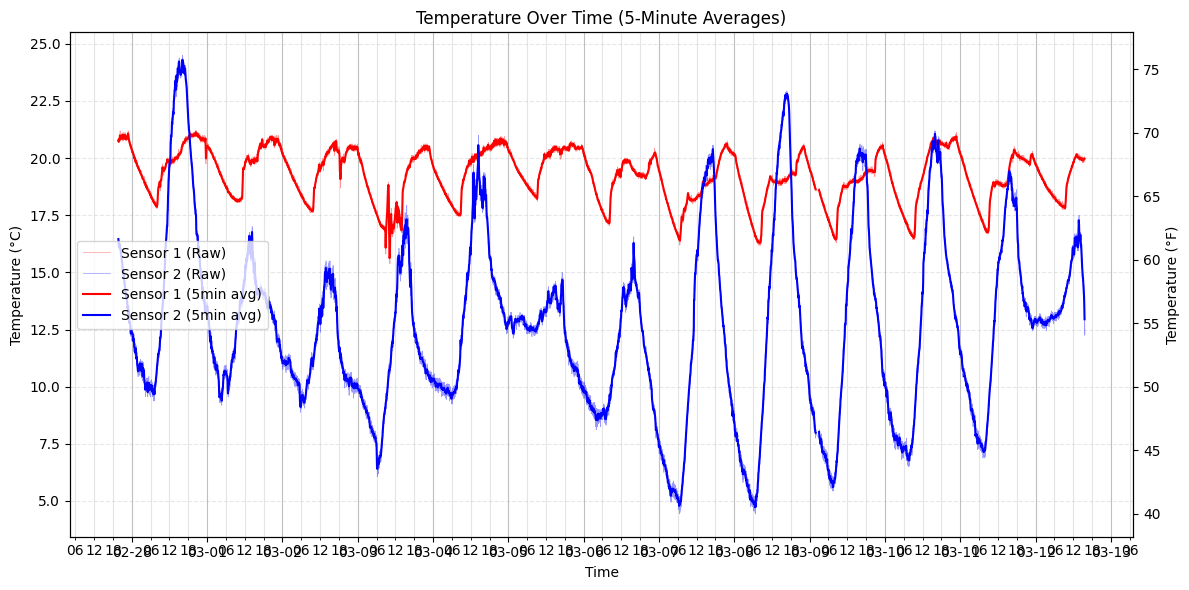

In [56]:
# Number of minutes to resample
resample_minutes = 5

# Resample data for both sensors
df_resampled1 = df.set_index('timestamp').resample(f'{resample_minutes}min')['temp1'].mean()
df_resampled2 = df.set_index('timestamp').resample(f'{resample_minutes}min')['temp2'].mean()

# Create the figure and axis with a larger size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create secondary axis for Fahrenheit
ax2 = ax1.twinx()

# Plot on primary axis (Celsius)
# Original data (thinner lines)
ax1.plot(df['timestamp'], df['temp1'], '-r', linewidth=0.5, alpha=0.4, label='Sensor 1 (Raw)')
ax1.plot(df['timestamp'], df['temp2'], '-b', linewidth=0.5, alpha=0.4, label='Sensor 2 (Raw)')

# Plot averaged temperature vs time (thicker lines)
ax1.plot(df_resampled1.index, df_resampled1.values, '-r', linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
ax1.plot(df_resampled2.index, df_resampled2.values, '-b', linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')

# Customize the plot
ax1.set_title(f'Temperature Over Time ({resample_minutes}-Minute Averages)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Temperature (°F)')

# Set up Fahrenheit axis limits based on Celsius limits
c_min, c_max = ax1.get_ylim()
ax2.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))

"""    # Hourly x-axis:
# Format x-axis to show date once per day and hours throughout
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_minor_locator(mdates.HourLocator())

# Set up grid with different styles for major (daily) and minor (hourly) lines
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)  # Darker daily lines
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)  # Lighter hourly lines
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)  # Regular horizontal grid
"""

# Daily x-axis:
# Format x-axis with custom time divisions
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Day format
ax1.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks at midnight

# Create custom 6-hour locator for minor ticks
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  # 6-hour intervals
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))  # Hour format

# Set up grid with different styles for midnight and 6-hour marks
ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)  # Darker midnight lines
ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)  # Lighter 6-hour lines
ax1.grid(True, axis='y', linestyle='--', alpha=0.3)  # Regular horizontal grid

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='center left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

### Find Night time

Find the region of data defined such that it begins where the smoothed df_resampled1 (indoors) temperature decays (specifically, does not increase) for 10 consecutive data points and ends just prior to where that temperature increases 4 consecutive times.

In [57]:
def find_cooling_segments(df_resampled1, df_resampled2, N_cooling=10, N_warming=4):
    """
    Find the region of data defined such that it begins where the smoothed df_resampled1 (indoors) temperature decays (specifically, does not increase) for 10 consecutive data points and ends just prior to where that temperature increases 4 consecutive times.
    
    Args:
        df_resampled1: pandas Series of indoor temperature data
        df_resampled2: pandas Series of outdoor temperature data
        N_cooling: number of consecutive data points where temperature does not increase
        N_warming: number of consecutive data points where temperature increases
    Returns:
        segments: list of dictionaries, each containing the start and end times of a cooling segment
    """
    # Calculate temperature differences
    temp_diff = df_resampled1.diff()
    
    # Find sequences where temperature is not increasing (diff <= 0)
    not_increasing = temp_diff <= 0
    
    segments = []
    i = 0
    
    while i < len(not_increasing) - N_cooling:
        # Look for cooling sequence start
        run_length = 0
        while i < len(not_increasing) - N_cooling:
            if not_increasing.iloc[i]:
                run_length += 1
                if run_length == N_cooling:
                    start_idx = i - N_cooling + 1  # Go back to start of sequence
                    break
            else:
                run_length = 0
            i += 1
            
        if i >= len(not_increasing) - N_cooling:
            break
            
        # Find end of sequence (N_warming consecutive increasing points)
        end_idx = start_idx + N_cooling
        while end_idx < len(temp_diff) - N_warming:
            if all(temp_diff.iloc[end_idx:end_idx + N_warming] > 0):
                break
            end_idx += 1
            
        # Get the timestamps for these indices
        start_time = not_increasing.index[start_idx]
        end_time = not_increasing.index[end_idx]
        
        # Select data for this time range
        mask = (df_resampled1.index >= start_time) & (df_resampled1.index < end_time)
        segment = {
            'start_time': start_time,
            'end_time': end_time,
            'temp1': df_resampled1[mask],
            'temp2': df_resampled2[mask]
        }
        segments.append(segment)
        
        # Move index past this segment
        i = end_idx + 1
    
    return segments

In [58]:
# Find all cooling segments
segments = find_cooling_segments(df_resampled1, df_resampled2)

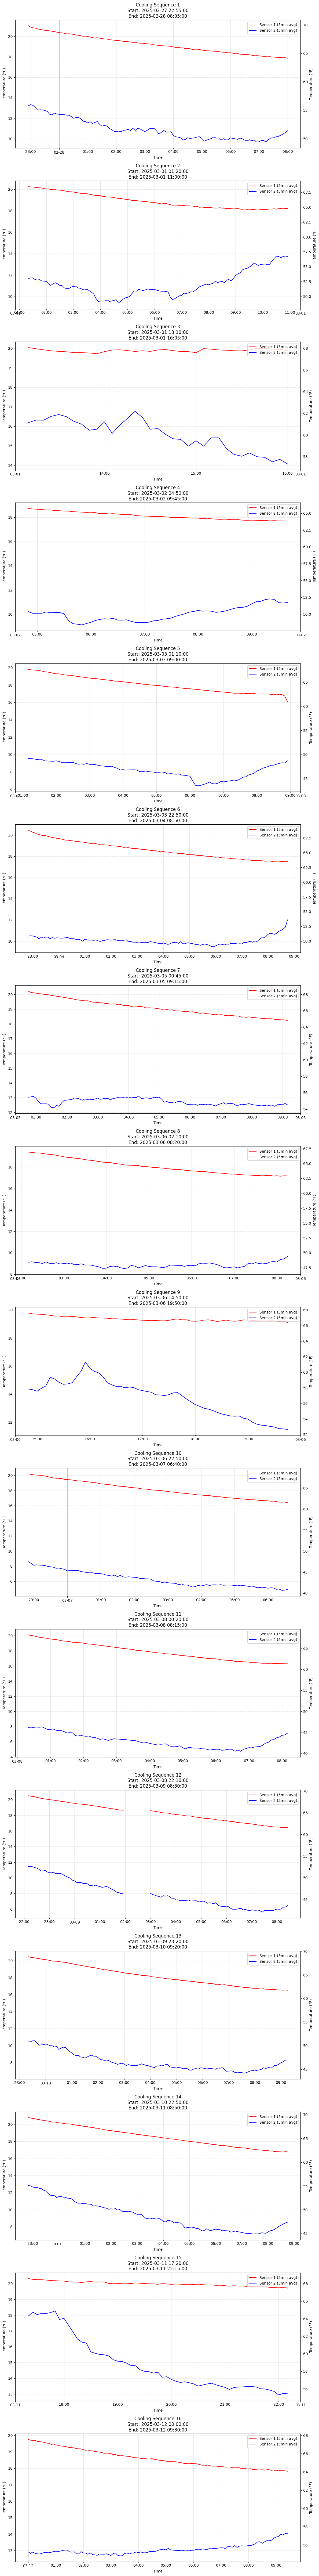

Found 16 cooling segments

Segment 1:
Start: 2025-02-27 22:55:00
End: 2025-02-28 08:05:00
Duration: 0 days 09:10:00

Segment 2:
Start: 2025-03-01 01:20:00
End: 2025-03-01 11:00:00
Duration: 0 days 09:40:00

Segment 3:
Start: 2025-03-01 13:10:00
End: 2025-03-01 16:05:00
Duration: 0 days 02:55:00

Segment 4:
Start: 2025-03-02 04:50:00
End: 2025-03-02 09:45:00
Duration: 0 days 04:55:00

Segment 5:
Start: 2025-03-03 01:10:00
End: 2025-03-03 09:00:00
Duration: 0 days 07:50:00

Segment 6:
Start: 2025-03-03 22:50:00
End: 2025-03-04 08:50:00
Duration: 0 days 10:00:00

Segment 7:
Start: 2025-03-05 00:45:00
End: 2025-03-05 09:15:00
Duration: 0 days 08:30:00

Segment 8:
Start: 2025-03-06 02:10:00
End: 2025-03-06 08:20:00
Duration: 0 days 06:10:00

Segment 9:
Start: 2025-03-06 14:50:00
End: 2025-03-06 19:50:00
Duration: 0 days 05:00:00

Segment 10:
Start: 2025-03-06 22:50:00
End: 2025-03-07 06:40:00
Duration: 0 days 07:50:00

Segment 11:
Start: 2025-03-08 00:20:00
End: 2025-03-08 08:15:00
Duration

In [59]:
# Plot all segments
fig, axes = plt.subplots(len(segments), 1, figsize=(12, 6*len(segments)))
if len(segments) == 1:
    axes = [axes]

for i, segment in enumerate(axes):
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # Plot the segment data
    ax1.plot(segments[i]['temp1'].index, segments[i]['temp1'].values, '-r', 
             linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
    ax1.plot(segments[i]['temp2'].index, segments[i]['temp2'].values, '-b', 
             linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
    
    # Customize the plot
    ax1.set_title(f'Cooling Sequence {i+1}\n'
                  f'Start: {segments[i]["start_time"]}\n'
                  f'End: {segments[i]["end_time"]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Temperature (°F)')
    
    # Set up Fahrenheit axis limits based on Celsius limits
    c_min, c_max = ax1.get_ylim()
    ax2.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
    
    # Set up grid
    ax1.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
    ax1.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    
    plt.xticks(rotation=45)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper right')

plt.tight_layout()
plt.show()

print(f"Found {len(segments)} cooling segments")
for i, segment in enumerate(segments):
    duration = segment['end_time'] - segment['start_time']
    print(f"\nSegment {i+1}:")
    print(f"Start: {segment['start_time']}")
    print(f"End: {segment['end_time']}")
    print(f"Duration: {duration}")

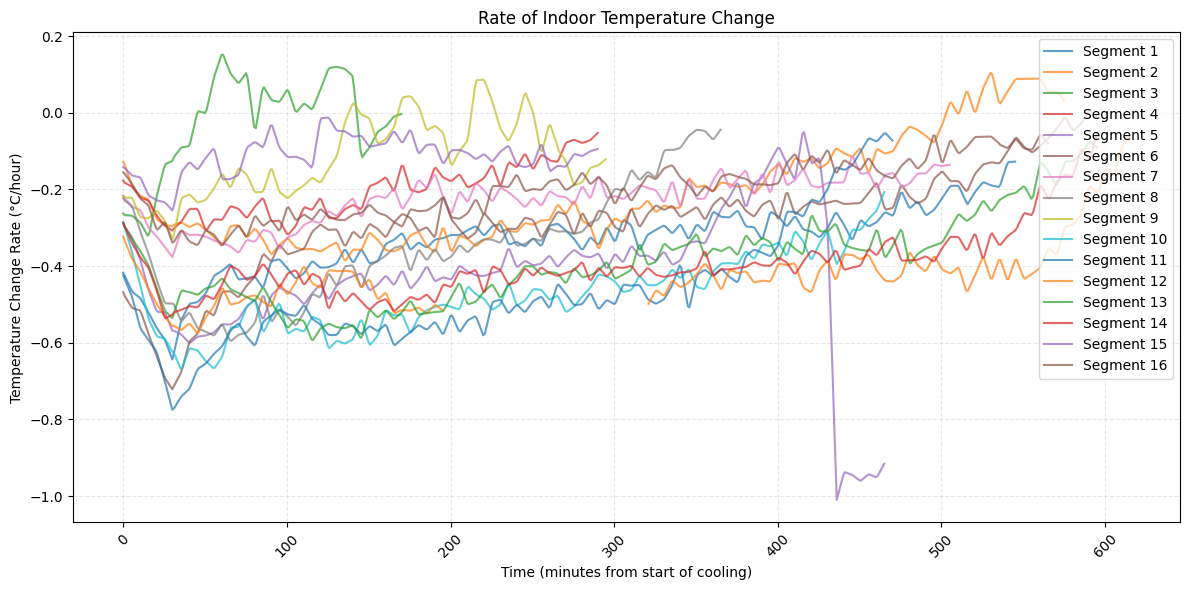

In [60]:
import numpy as np
# Create the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Process and plot each segment
for i, segment in enumerate(segments):
    # First resample to regular intervals and interpolate
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    
    # Convert to minutes from start of segment
    time_minutes = (regular_time - regular_time[0]).total_seconds() / 60.0
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=time_minutes,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Plot smoothed derivative
    ax1.plot(time_minutes, dT_dt_smooth, '-', alpha=0.7, 
             label=f'Segment {i+1}')

# Customize the plot
ax1.set_title('Rate of Indoor Temperature Change')
ax1.set_xlabel('Time (minutes from start of cooling)')
ax1.set_ylabel('Temperature Change Rate (°C/hour)')

# Set up grid
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

plt.xticks(rotation=45)

# Add legend
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

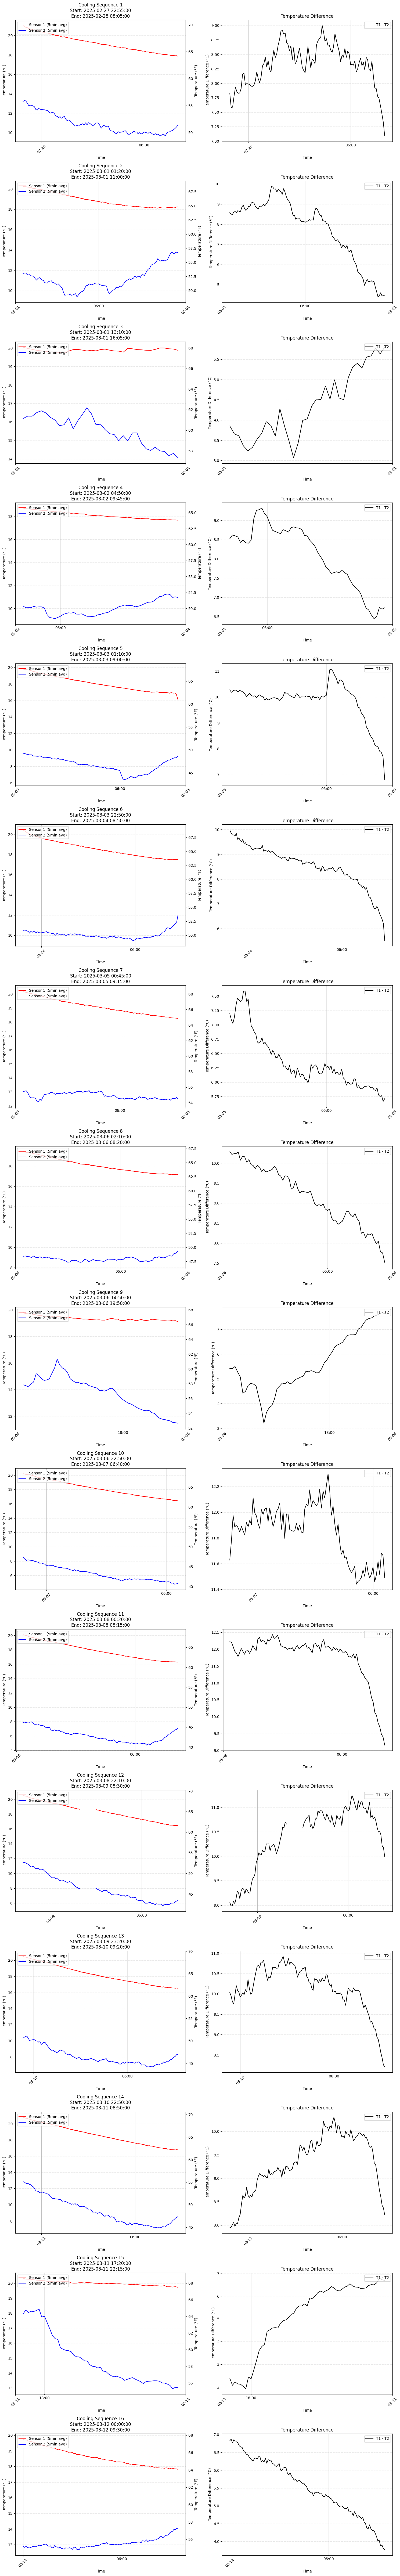


Found 16 cooling segments

Segment 1:
Start: 2025-02-27 22:55:00
End: 2025-02-28 08:05:00
Duration: 0 days 09:10:00
Mean temperature difference: 8.32°C
Max temperature difference: 9.00°C
Min temperature difference: 7.09°C

Segment 2:
Start: 2025-03-01 01:20:00
End: 2025-03-01 11:00:00
Duration: 0 days 09:40:00
Mean temperature difference: 7.76°C
Max temperature difference: 9.88°C
Min temperature difference: 4.40°C

Segment 3:
Start: 2025-03-01 13:10:00
End: 2025-03-01 16:05:00
Duration: 0 days 02:55:00
Mean temperature difference: 4.34°C
Max temperature difference: 5.80°C
Min temperature difference: 3.07°C

Segment 4:
Start: 2025-03-02 04:50:00
End: 2025-03-02 09:45:00
Duration: 0 days 04:55:00
Mean temperature difference: 8.09°C
Max temperature difference: 9.32°C
Min temperature difference: 6.45°C

Segment 5:
Start: 2025-03-03 01:10:00
End: 2025-03-03 09:00:00
Duration: 0 days 07:50:00
Mean temperature difference: 9.85°C
Max temperature difference: 11.08°C
Min temperature difference:

In [50]:
# Plot all segments
fig, axes = plt.subplots(len(segments), 2, figsize=(15, 6*len(segments)))
if len(segments) == 1:
    axes = [axes]

for i, (ax1, ax2) in enumerate(axes):
    # Create secondary y-axis for Fahrenheit
    ax1_f = ax1.twinx()
    
    # Plot temperatures on first subplot
    ax1.plot(segments[i]['temp1'].index, segments[i]['temp1'].values, '-r', 
             linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
    ax1.plot(segments[i]['temp2'].index, segments[i]['temp2'].values, '-b', 
             linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
    
    # Calculate and plot temperature difference on second subplot
    temp_diff = segments[i]['temp1'] - segments[i]['temp2']
    ax2.plot(temp_diff.index, temp_diff.values, '-k', 
             linewidth=1.5, label='T1 - T2')
    
    # Customize the temperature plot
    ax1.set_title(f'Cooling Sequence {i+1}\n'
                  f'Start: {segments[i]["start_time"]}\n'
                  f'End: {segments[i]["end_time"]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax1_f.set_ylabel('Temperature (°F)')
    
    # Set up Fahrenheit axis limits based on Celsius limits
    c_min, c_max = ax1.get_ylim()
    ax1_f.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
    
    # Customize the difference plot
    ax2.set_title(f'Temperature Difference')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature Difference (°C)')
    
    # Set up grid for both plots
    for ax in [ax1, ax2]:
        # Format x-axis with custom time divisions
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
        
        # Set up grid with different styles
        ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
        ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics for each segment
print(f"\nFound {len(segments)} cooling segments")
for i, segment in enumerate(segments):
    temp_diff = segment['temp1'] - segment['temp2']
    duration = segment['end_time'] - segment['start_time']
    print(f"\nSegment {i+1}:")
    print(f"Start: {segment['start_time']}")
    print(f"End: {segment['end_time']}")
    print(f"Duration: {duration}")
    print(f"Mean temperature difference: {temp_diff.mean():.2f}°C")
    print(f"Max temperature difference: {temp_diff.max():.2f}°C")
    print(f"Min temperature difference: {temp_diff.min():.2f}°C")
    

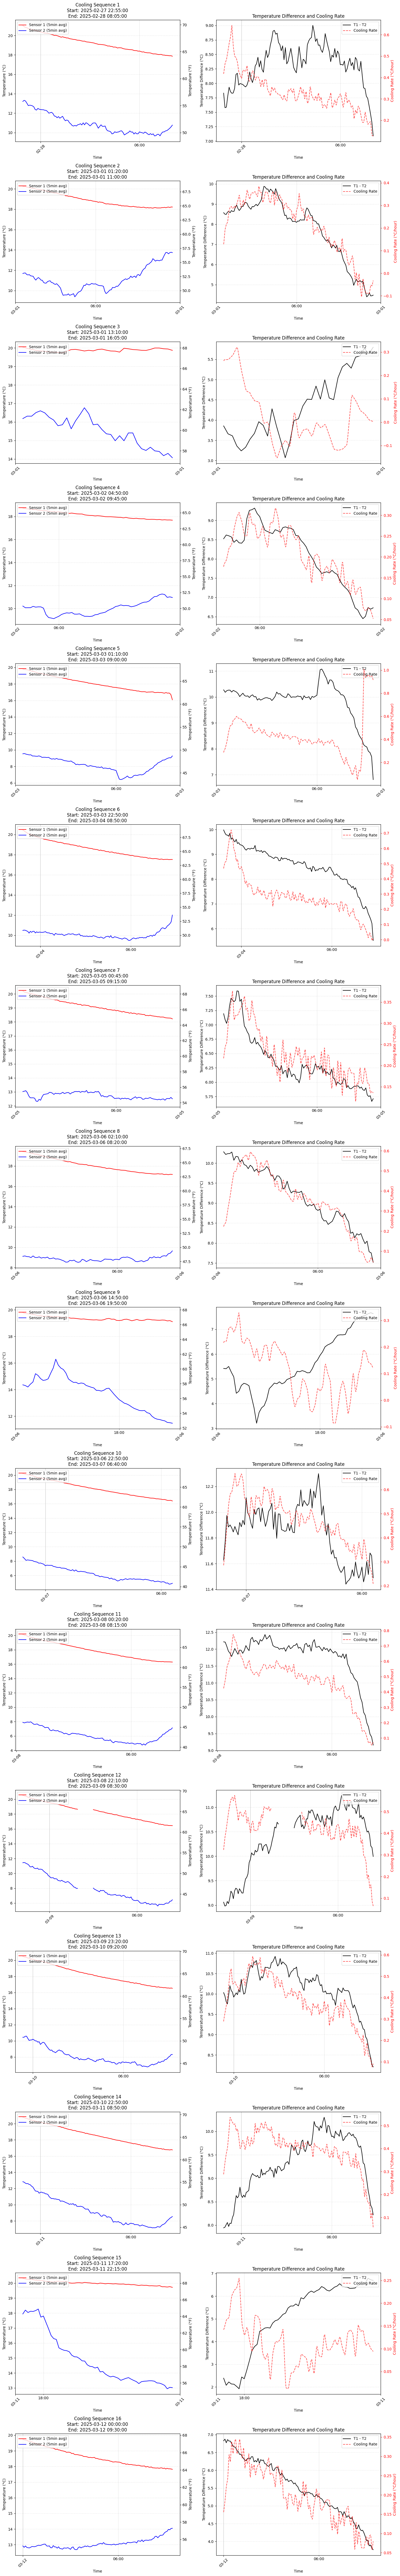


Found 16 cooling segments

Segment 1:
Start: 2025-02-27 22:55:00
End: 2025-02-28 08:05:00
Duration: 0 days 09:10:00
Mean temperature difference: 8.32°C
Max temperature difference: 9.00°C
Min temperature difference: 7.09°C

Segment 2:
Start: 2025-03-01 01:20:00
End: 2025-03-01 11:00:00
Duration: 0 days 09:40:00
Mean temperature difference: 7.76°C
Max temperature difference: 9.88°C
Min temperature difference: 4.40°C

Segment 3:
Start: 2025-03-01 13:10:00
End: 2025-03-01 16:05:00
Duration: 0 days 02:55:00
Mean temperature difference: 4.34°C
Max temperature difference: 5.80°C
Min temperature difference: 3.07°C

Segment 4:
Start: 2025-03-02 04:50:00
End: 2025-03-02 09:45:00
Duration: 0 days 04:55:00
Mean temperature difference: 8.09°C
Max temperature difference: 9.32°C
Min temperature difference: 6.45°C

Segment 5:
Start: 2025-03-03 01:10:00
End: 2025-03-03 09:00:00
Duration: 0 days 07:50:00
Mean temperature difference: 9.85°C
Max temperature difference: 11.08°C
Min temperature difference:

In [12]:
# Plot all segments
fig, axes = plt.subplots(len(segments), 2, figsize=(15, 6*len(segments)))
if len(segments) == 1:
    axes = [axes]

for i, (ax1, ax2) in enumerate(axes):
    # Create secondary y-axes
    ax1_f = ax1.twinx()  # Fahrenheit axis
    ax2_rate = ax2.twinx()  # Cooling rate axis
    
    # Plot temperatures on first subplot
    ax1.plot(segments[i]['temp1'].index, segments[i]['temp1'].values, '-r', 
             linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
    ax1.plot(segments[i]['temp2'].index, segments[i]['temp2'].values, '-b', 
             linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
    
    # Calculate and plot temperature difference on second subplot
    temp_diff = segments[i]['temp1'] - segments[i]['temp2']
    ax2.plot(temp_diff.index, temp_diff.values, '-k', 
             linewidth=1.5, label='T1 - T2')
    
    # Calculate and plot cooling rate
    # First resample to regular intervals and interpolate
    regular_time = pd.date_range(start=segments[i]['temp1'].index[0], 
                               end=segments[i]['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segments[i]['temp1'].index),
                                        segments[i]['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Plot negative cooling rate (to show positive values for cooling)
    ax2_rate.plot(regular_time, -dT_dt_smooth, '--r', alpha=0.7, 
                  label='Cooling Rate')
    
    # Customize the temperature plot
    ax1.set_title(f'Cooling Sequence {i+1}\n'
                  f'Start: {segments[i]["start_time"]}\n'
                  f'End: {segments[i]["end_time"]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax1_f.set_ylabel('Temperature (°F)')
    
    # Set up Fahrenheit axis limits based on Celsius limits
    c_min, c_max = ax1.get_ylim()
    ax1_f.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
    
    # Customize the difference/rate plot
    ax2.set_title(f'Temperature Difference and Cooling Rate')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature Difference (°C)')
    ax2_rate.set_ylabel('Cooling Rate (°C/hour)', color='r')
    
    # Set up grid for both plots
    for ax in [ax1, ax2]:
        # Format x-axis with custom time divisions
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
        
        # Set up grid with different styles
        ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
        ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Color cooling rate ticks red
    ax2_rate.tick_params(axis='y', colors='r')
    
    # Add legends
    ax1.legend(loc='upper left')
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines2_rate, labels2_rate = ax2_rate.get_legend_handles_labels()
    ax2.legend(lines2 + lines2_rate, labels2 + labels2_rate, loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics for each segment
print(f"\nFound {len(segments)} cooling segments")
for i, segment in enumerate(segments):
    temp_diff = segment['temp1'] - segment['temp2']
    duration = segment['end_time'] - segment['start_time']
    print(f"\nSegment {i+1}:")
    print(f"Start: {segment['start_time']}")
    print(f"End: {segment['end_time']}")
    print(f"Duration: {duration}")
    print(f"Mean temperature difference: {temp_diff.mean():.2f}°C")
    print(f"Max temperature difference: {temp_diff.max():.2f}°C")
    print(f"Min temperature difference: {temp_diff.min():.2f}°C")

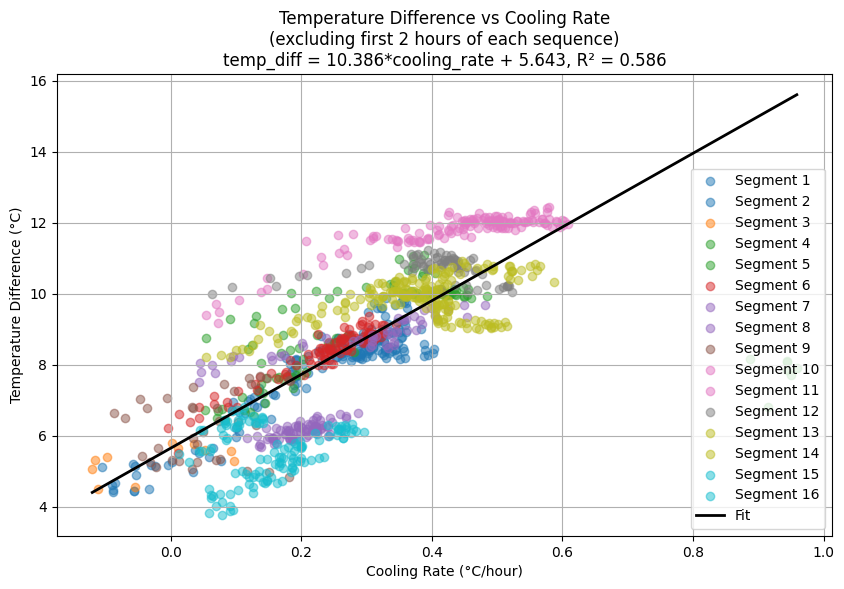


Fit Results:
A = 10.386 ± 0.265 °C/(°C/hour)
b = 5.643 ± 0.087 °C
R² = 0.586


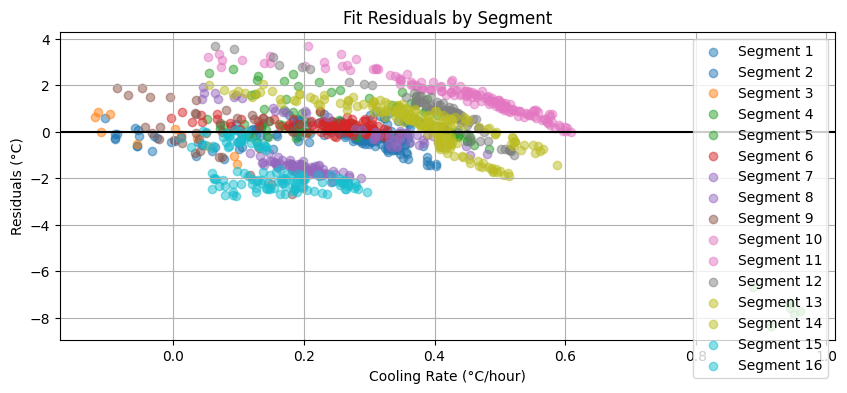

In [13]:
from scipy.optimize import curve_fit
import numpy as np

# Define a colormap for different segments
colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))

# Create the figure
plt.figure(figsize=(10, 6))

# Collect all valid data points across segments
all_temp_diffs = []
all_cooling_rates = []

# First pass to collect all data for the fit
for segment in segments:
    # Get temperature difference data
    temp_diff = segment['temp1'] - segment['temp2']
    
    # Calculate cooling rate with same time base
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Truncate first 2 hours
    start_time = regular_time[0] + pd.Timedelta(hours=2)
    mask = regular_time >= start_time
    
    # Collect valid data points
    all_temp_diffs.extend(temp_diff.reindex(regular_time[mask]).values)
    all_cooling_rates.extend(-dT_dt_smooth[mask].values)  # Note negative sign for cooling rate

# Convert to numpy arrays
X = np.array(all_cooling_rates)
y = np.array(all_temp_diffs)

# Remove any NaN values
valid_mask = ~np.isnan(X) & ~np.isnan(y)
X = X[valid_mask]
y = y[valid_mask]

# Define fitting function: temp_diff = A*cooling_rate + b
def fit_func(x, A, b):
    return A*x + b

# Perform the fit
popt, pcov = curve_fit(fit_func, X, y)
A, b = popt
A_err, b_err = np.sqrt(np.diag(pcov))

# Now plot each segment in a different color
for i, segment in enumerate(segments):
    # Get temperature difference data
    temp_diff = segment['temp1'] - segment['temp2']
    
    # Calculate cooling rate
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Truncate first 2 hours
    start_time = regular_time[0] + pd.Timedelta(hours=2)
    mask = regular_time >= start_time
    
    # Plot this segment's data
    plt.scatter(-dT_dt_smooth[mask], temp_diff.reindex(regular_time[mask]), 
                alpha=0.5, color=colors[i], label=f'Segment {i+1}')

# Plot the fit line
x_fit = np.linspace(min(X), max(X), 100)
plt.plot(x_fit, fit_func(x_fit, A, b), 'k-', label='Fit', linewidth=2)

# Calculate R-squared
residuals = y - fit_func(X, A, b)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Add labels and title
plt.xlabel('Cooling Rate (°C/hour)')
plt.ylabel('Temperature Difference (°C)')
plt.title('Temperature Difference vs Cooling Rate\n' + 
          f'(excluding first 2 hours of each sequence)\n' +
          f'temp_diff = {A:.3f}*cooling_rate + {b:.3f}, R² = {r_squared:.3f}')
plt.legend()
plt.grid(True)
plt.show()

# Print fit results
print(f"\nFit Results:")
print(f"A = {A:.3f} ± {A_err:.3f} °C/(°C/hour)")
print(f"b = {b:.3f} ± {b_err:.3f} °C")
print(f"R² = {r_squared:.3f}")

# Optional: Plot residuals with different colors for each segment
plt.figure(figsize=(10, 4))
for i, segment in enumerate(segments):
    temp_diff = segment['temp1'] - segment['temp2']
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    dT_dt = np.gradient(temp_interp.values) / (1/60)
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(60)/60, mode='same'))
    start_time = regular_time[0] + pd.Timedelta(hours=2)
    mask = regular_time >= start_time
    
    X_seg = -dT_dt_smooth[mask]
    y_seg = temp_diff.reindex(regular_time[mask])
    residuals = y_seg - fit_func(X_seg, A, b)
    plt.scatter(X_seg, residuals, alpha=0.5, color=colors[i], label=f'Segment {i+1}')

plt.axhline(y=0, color='k', linestyle='-')
plt.xlabel('Cooling Rate (°C/hour)')
plt.ylabel('Residuals (°C)')
plt.title('Fit Residuals by Segment')
plt.legend()
plt.grid(True)
plt.show()

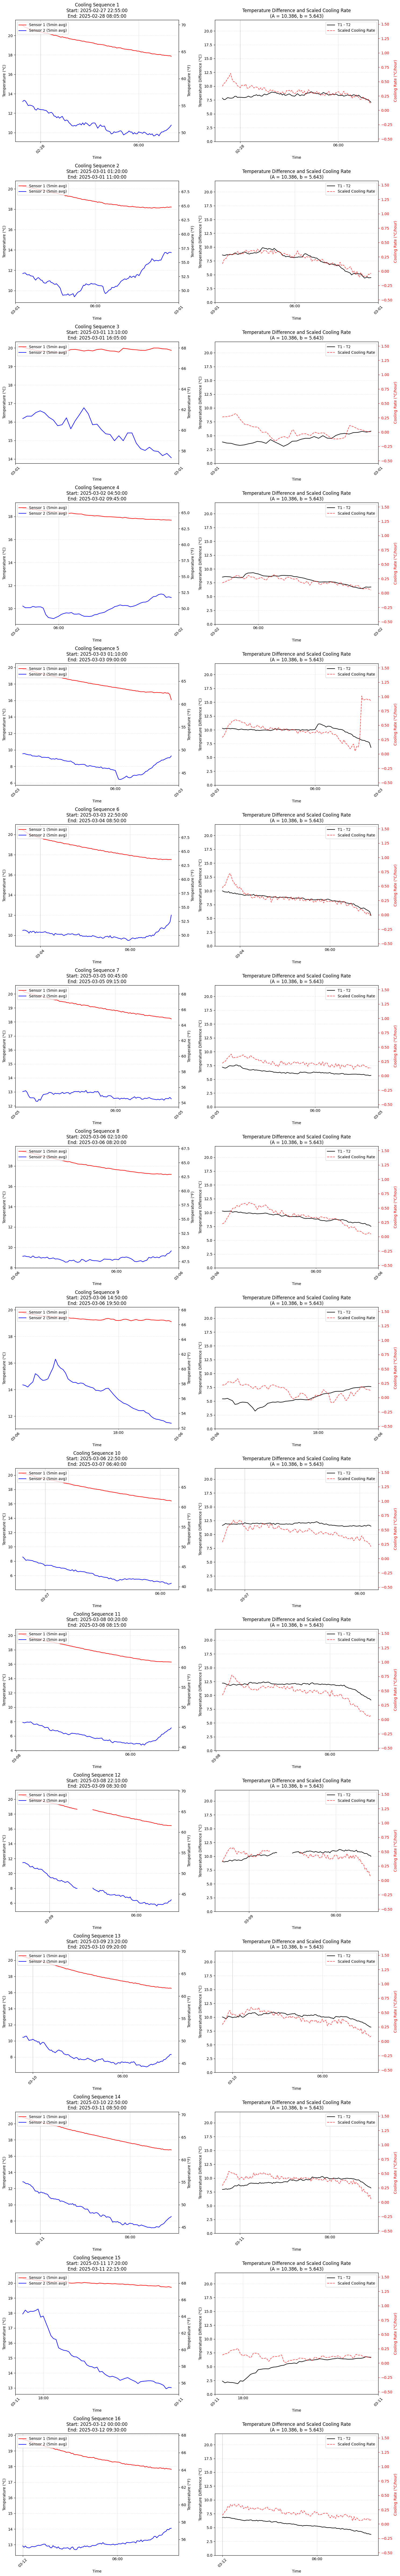

In [14]:
# Plot all segments
fig, axes = plt.subplots(len(segments), 2, figsize=(15, 6*len(segments)))
if len(segments) == 1:
    axes = [axes]

for i, (ax1, ax2) in enumerate(axes):
    # Create secondary y-axes
    ax1_f = ax1.twinx()  # Fahrenheit axis
    ax2_rate = ax2.twinx()  # Cooling rate axis
    
    # Plot temperatures on first subplot
    ax1.plot(segments[i]['temp1'].index, segments[i]['temp1'].values, '-r', 
             linewidth=1.5, label=f'Sensor 1 ({resample_minutes}min avg)')
    ax1.plot(segments[i]['temp2'].index, segments[i]['temp2'].values, '-b', 
             linewidth=1.5, label=f'Sensor 2 ({resample_minutes}min avg)')
    
    # Calculate and plot temperature difference on second subplot
    temp_diff = segments[i]['temp1'] - segments[i]['temp2']
    ax2.plot(temp_diff.index, temp_diff.values, '-k', 
             linewidth=1.5, label='T1 - T2')
    
    # Calculate cooling rate
    regular_time = pd.date_range(start=segments[i]['temp1'].index[0], 
                               end=segments[i]['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segments[i]['temp1'].index),
                                        segments[i]['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Plot scaled cooling rate: A*(-dT_dt_smooth) + b
    scaled_cooling = A*(-dT_dt_smooth) + b
    ax2.plot(regular_time, scaled_cooling, '--r', alpha=0.7, 
             label='Scaled Cooling Rate')
    
    # Find the ranges needed for both datasets
    diff_min = temp_diff.min()
    diff_max = temp_diff.max()
    
    # Set y1 limits to include all temperature difference data
    y1_min = min(0, diff_min)
    y1_max = max(22, diff_max)
    ax2.set_ylim(y1_min, y1_max)
    
    # Calculate corresponding y2 limits using y2 = (y1 - b)/A
    y2_min = (y1_min - b)/A
    y2_max = (y1_max - b)/A
    ax2_rate.set_ylim(y2_min, y2_max)
    
    # Customize the temperature plot
    ax1.set_title(f'Cooling Sequence {i+1}\n'
                  f'Start: {segments[i]["start_time"]}\n'
                  f'End: {segments[i]["end_time"]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)')
    ax1_f.set_ylabel('Temperature (°F)')
    
    # Set up Fahrenheit axis limits
    c_min, c_max = ax1.get_ylim()
    ax1_f.set_ylim((c_min * 9/5 + 32), (c_max * 9/5 + 32))
    
    # Customize the difference/rate plot
    ax2.set_title(f'Temperature Difference and Scaled Cooling Rate\n'
                  f'(A = {A:.3f}, b = {b:.3f})')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature Difference (°C)')
    ax2_rate.set_ylabel('Cooling Rate (°C/hour)', color='r')
    
    # Set up grid for both plots
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:00'))
        ax.grid(True, which='major', axis='x', linestyle='-', color='gray', alpha=0.5)
        ax.grid(True, which='minor', axis='x', linestyle='-', color='gray', alpha=0.2)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Color cooling rate ticks red
    ax2_rate.tick_params(axis='y', colors='r')
    
    # Add legends
    ax1.legend(loc='upper left')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines2, labels2, loc='upper right')

plt.tight_layout()
plt.show()

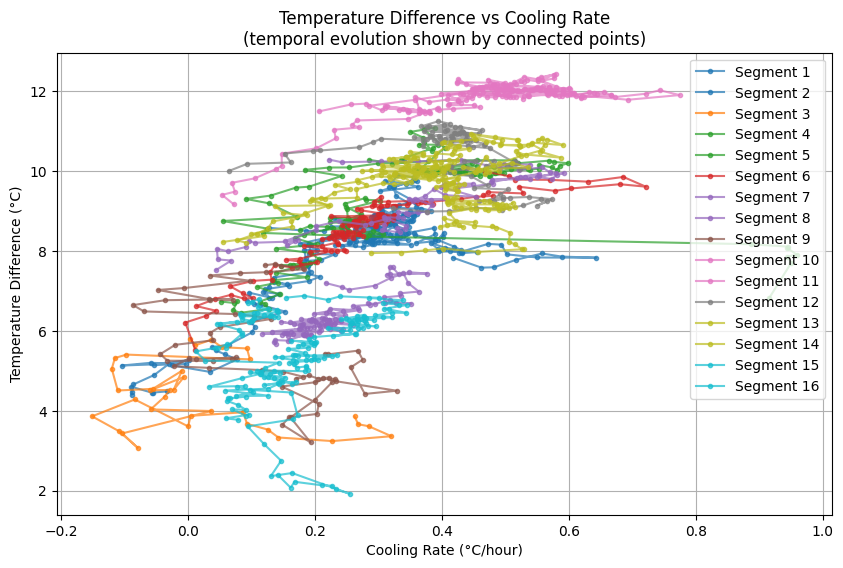

In [15]:
# Define a colormap for different segments
colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each segment with temporal connection
for i, segment in enumerate(segments):
    # Get temperature difference data
    temp_diff = segment['temp1'] - segment['temp2']
    
    # Calculate cooling rate
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Get x and y data
    x_data = -dT_dt_smooth
    y_data = temp_diff.reindex(regular_time)
    
    # Remove any NaN values
    mask = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_data = x_data[mask]
    y_data = y_data[mask]
    
    # Plot this segment's data
    plt.plot(x_data, y_data, '-o', color=colors[i], 
            label=f'Segment {i+1}', alpha=0.7, markersize=3)

plt.xlabel('Cooling Rate (°C/hour)')
plt.ylabel('Temperature Difference (°C)')
plt.title('Temperature Difference vs Cooling Rate\n(temporal evolution shown by connected points)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timedelta
import pandas as pd
from zoneinfo import ZoneInfo

# Define Livermore, CA location
livermore = LocationInfo('Livermore', 'California', 'US', 37.6819, -121.7680)

# Create date range for Feb and March 2025
start_date = datetime(2025, 2, 1)
end_date = datetime(2025, 3, 31)
dates = pd.date_range(start=start_date, end=end_date)

# Get sunrise times and convert to Pacific Time
sunrise_times = []
for date in dates:
    s = sun(livermore.observer, date=date)
    # Convert UTC to Pacific Time
    pacific_sunrise = s['sunrise'].astimezone(ZoneInfo('America/Los_Angeles'))
    sunrise_times.append(pacific_sunrise.strftime('%H:%M'))

# Create DataFrame
df = pd.DataFrame({
    'Date': dates.strftime('%Y-%m-%d'),
    'Sunrise (PT)': sunrise_times
})

# Display table
print(df.to_string(index=False))

      Date Sunrise (PT)
2025-02-01        07:10
2025-02-02        07:09
2025-02-03        07:08
2025-02-04        07:08
2025-02-05        07:07
2025-02-06        07:06
2025-02-07        07:05
2025-02-08        07:04
2025-02-09        07:03
2025-02-10        07:01
2025-02-11        07:00
2025-02-12        06:59
2025-02-13        06:58
2025-02-14        06:57
2025-02-15        06:56
2025-02-16        06:55
2025-02-17        06:53
2025-02-18        06:52
2025-02-19        06:51
2025-02-20        06:50
2025-02-21        06:48
2025-02-22        06:47
2025-02-23        06:46
2025-02-24        06:44
2025-02-25        06:43
2025-02-26        06:42
2025-02-27        06:40
2025-02-28        06:39
2025-03-01        06:38
2025-03-02        06:36
2025-03-03        06:35
2025-03-04        06:33
2025-03-05        06:32
2025-03-06        06:31
2025-03-07        06:29
2025-03-08        06:28
2025-03-09        07:26
2025-03-10        07:25
2025-03-11        07:23
2025-03-12        07:22
2025-03-13      

In [17]:

from astral import LocationInfo
from astral.sun import sun
from zoneinfo import ZoneInfo
from datetime import timedelta

# Define Livermore location
livermore = LocationInfo('Livermore', 'California', 'US', 37.6819, -121.7680)

# Function to get sunrise time for a given date
def get_sunrise(date):
    s = sun(livermore.observer, date=date)
    return s['sunrise'].astimezone(ZoneInfo('America/Los_Angeles')).replace(tzinfo=None)


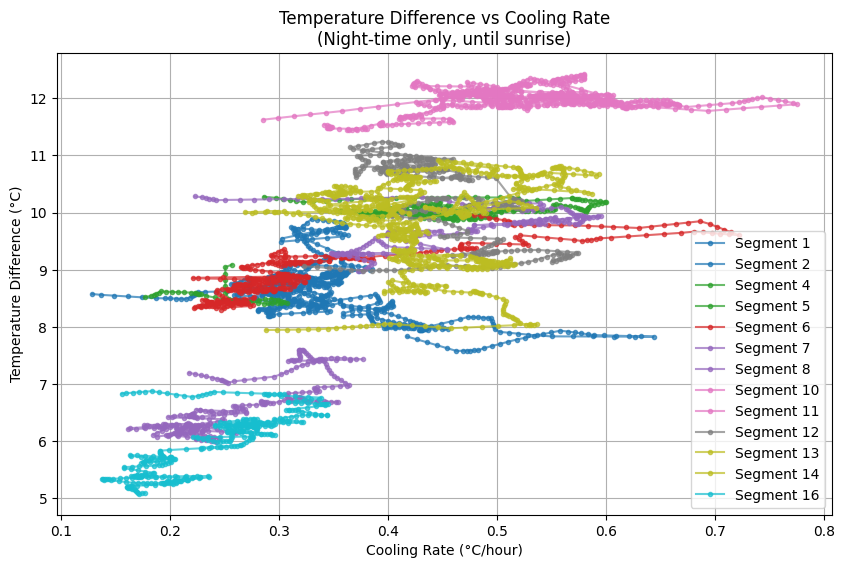

In [18]:
# Define a colormap for different segments
colors = plt.cm.tab10(np.linspace(0, 1, len(segments)))

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each segment with temporal connection
for i, segment in enumerate(segments):
    # Get temperature difference data
    temp_diff = segment['temp1'] - segment['temp2']
    
    # Calculate cooling rate
    regular_time = pd.date_range(start=segment['temp1'].index[0], 
                               end=segment['temp1'].index[-1],
                               freq='1min')
    
    temp_interp = pd.Series(index=regular_time, 
                           data=np.interp(mdates.date2num(regular_time),
                                        mdates.date2num(segment['temp1'].index),
                                        segment['temp1'].values))
    
    # Calculate derivative and smooth it
    window = 60  # 1 hour window for smoothing
    dt = 1/60  # time step in hours
    dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
    dT_dt_smooth = pd.Series(index=regular_time,
                            data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
    
    # Get x and y data
    x_data = -dT_dt_smooth
    y_data = pd.Series(index=regular_time,
                       data=np.interp(mdates.date2num(regular_time),
                                    mdates.date2num(temp_diff.index),
                                    temp_diff.values))
    
    # NOW apply the sunrise mask; after smoothing.
    end_date = segment['temp1'].index[-1].date()
    sunrise = get_sunrise(end_date) - timedelta(minutes=60)
    mask = regular_time.to_pydatetime() < sunrise
    
    # Apply mask to data
    x_data = x_data[mask]
    y_data = y_data[mask]
    
    # Remove any NaN values
    mask = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_data = x_data[mask]
    y_data = y_data[mask]
    
    # Plot this segment's data
    if len(x_data) > 0:
        plt.plot(x_data, y_data, '-o', color=colors[i], 
                label=f'Segment {i+1}', alpha=0.7, markersize=3)

plt.xlabel('Cooling Rate (°C/hour)')
plt.ylabel('Temperature Difference (°C)')
plt.title('Temperature Difference vs Cooling Rate\n(Night-time only, until sunrise)')
plt.legend()
plt.grid(True)
plt.show()

---

In [19]:
timedelta(minutes=90)

datetime.timedelta(seconds=5400)

In [20]:
segment = segments[0]

In [39]:
segment

{'start_time': Timestamp('2025-03-12 00:00:00'),
 'end_time': Timestamp('2025-03-12 09:30:00'),
 'temp1': timestamp
 2025-03-12 00:00:00    19.749000
 2025-03-12 00:05:00    19.702222
 2025-03-12 00:10:00    19.688000
 2025-03-12 00:15:00    19.686667
 2025-03-12 00:20:00    19.624000
                          ...    
 2025-03-12 09:05:00    17.884444
 2025-03-12 09:10:00    17.853000
 2025-03-12 09:15:00    17.851000
 2025-03-12 09:20:00    17.841111
 2025-03-12 09:25:00    17.818000
 Freq: 5min, Name: temp1, Length: 114, dtype: float64,
 'temp2': timestamp
 2025-03-12 00:00:00    12.921000
 2025-03-12 00:05:00    12.828889
 2025-03-12 00:10:00    12.916000
 2025-03-12 00:15:00    12.826667
 2025-03-12 00:20:00    12.803000
                          ...    
 2025-03-12 09:05:00    13.855556
 2025-03-12 09:10:00    13.976000
 2025-03-12 09:15:00    13.951000
 2025-03-12 09:20:00    14.034444
 2025-03-12 09:25:00    14.048000
 Freq: 5min, Name: temp2, Length: 114, dtype: float64}

In [21]:
segment['temp1'].index

DatetimeIndex(['2025-02-27 22:55:00', '2025-02-27 23:00:00',
               '2025-02-27 23:05:00', '2025-02-27 23:10:00',
               '2025-02-27 23:15:00', '2025-02-27 23:20:00',
               '2025-02-27 23:25:00', '2025-02-27 23:30:00',
               '2025-02-27 23:35:00', '2025-02-27 23:40:00',
               ...
               '2025-02-28 07:15:00', '2025-02-28 07:20:00',
               '2025-02-28 07:25:00', '2025-02-28 07:30:00',
               '2025-02-28 07:35:00', '2025-02-28 07:40:00',
               '2025-02-28 07:45:00', '2025-02-28 07:50:00',
               '2025-02-28 07:55:00', '2025-02-28 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=110, freq='5min')

In [22]:
mask = pd.Series(True, index=segment['temp1'].index)

In [23]:
end_date = segment['temp1'].index[-1].date()
sunrise = get_sunrise(end_date) #- timedelta(minutes=120)
mask &= segment['temp1'].index.to_pydatetime() < sunrise
end_date, get_sunrise(end_date), segment['temp1'][mask].index[-1]

(datetime.date(2025, 2, 28),
 datetime.datetime(2025, 2, 28, 6, 39, 30, 553109),
 Timestamp('2025-02-28 06:35:00'))

In [24]:
# Apply the mask to the segment data
filtered_temp1 = segment['temp1'][mask]
filtered_temp2 = segment['temp2'][mask]

In [25]:
len(filtered_temp2)

93

In [26]:
len(segment['temp2'])


110

In [27]:
temp_diff = filtered_temp1 - filtered_temp2

filtered_temp1 = segment['temp1'][mask]
regular_time = pd.date_range(start=filtered_temp1.index[0], 
                             end=filtered_temp1.index[-1],
                             freq='1min')
temp_interp = pd.Series(index=regular_time, 
                        data=np.interp(mdates.date2num(regular_time),
                        mdates.date2num(filtered_temp1.index),
                        filtered_temp1.values))

# Calculate derivative and smooth it
window = 60  # 1 hour window for smoothing
dt = 1/60 #60  # time step in hours
dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
dT_dt_smooth = pd.Series(index=regular_time,
                         data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))



In [28]:
dT_dt_smooth

2025-02-27 22:55:00   -0.417044
2025-02-27 22:56:00   -0.426267
2025-02-27 22:57:00   -0.435289
2025-02-27 22:58:00   -0.444311
2025-02-27 22:59:00   -0.453333
                         ...   
2025-02-28 06:31:00   -0.172767
2025-02-28 06:32:00   -0.163411
2025-02-28 06:33:00   -0.154056
2025-02-28 06:34:00   -0.144700
2025-02-28 06:35:00   -0.135344
Freq: min, Length: 461, dtype: float64

In [29]:
x_data = -dT_dt_smooth
#y_data = temp_diff.reindex(regular_time)
y_data = pd.Series(index=regular_time,
                   data=np.interp(mdates.date2num(regular_time),
                                mdates.date2num(temp_diff.index),
                                temp_diff.values))

In [30]:
y_data


2025-02-27 22:55:00    7.830000
2025-02-27 22:56:00    7.779556
2025-02-27 22:57:00    7.729111
2025-02-27 22:58:00    7.678667
2025-02-27 22:59:00    7.628222
                         ...   
2025-02-28 06:31:00    8.370156
2025-02-28 06:32:00    8.385867
2025-02-28 06:33:00    8.401578
2025-02-28 06:34:00    8.417289
2025-02-28 06:35:00    8.433000
Freq: min, Length: 461, dtype: float64

In [31]:
mask = ~np.isnan(x_data) & ~np.isnan(y_data)

In [32]:
x_data[mask]


2025-02-27 22:55:00    0.417044
2025-02-27 22:56:00    0.426267
2025-02-27 22:57:00    0.435289
2025-02-27 22:58:00    0.444311
2025-02-27 22:59:00    0.453333
                         ...   
2025-02-28 06:31:00    0.172767
2025-02-28 06:32:00    0.163411
2025-02-28 06:33:00    0.154056
2025-02-28 06:34:00    0.144700
2025-02-28 06:35:00    0.135344
Freq: min, Length: 461, dtype: float64

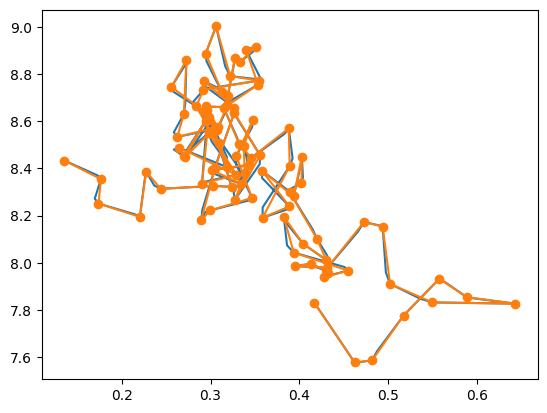

In [33]:
plt.plot(x_data, y_data)

# Get x and y data
x_data = -dT_dt_smooth
y_data = temp_diff.reindex(regular_time)

# Remove any NaN values
mask = ~np.isnan(x_data) & ~np.isnan(y_data)
x_data = x_data[mask]
y_data = y_data[mask]


# Plot this segment's data
plt.plot(x_data, y_data, '-o') #, color=colors[i], 
        #label=f'Segment {i+1}', alpha=0.7, markersize=3)

#plt.grid(True)
plt.show()

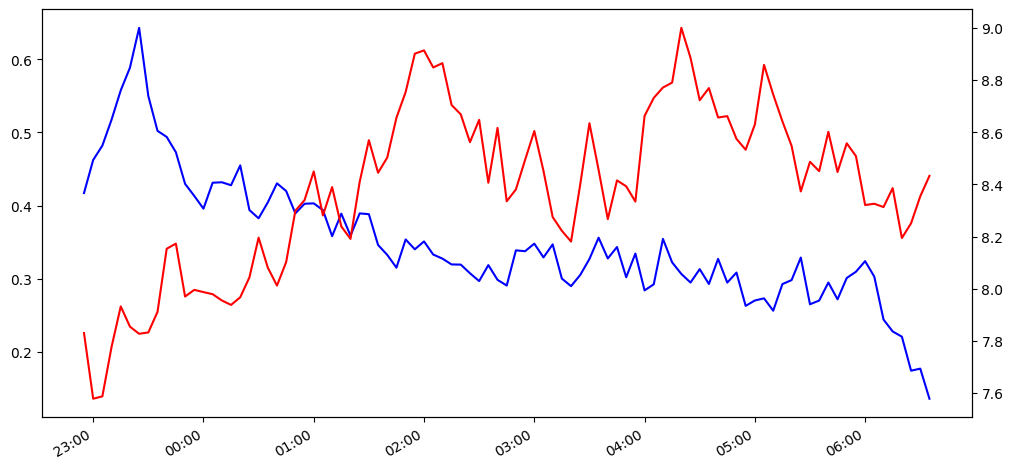

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(regular_time[mask], x_data, color='blue')
ax2.plot(regular_time[mask], y_data, color='red')

# Configure x-axis for better time display
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.show()


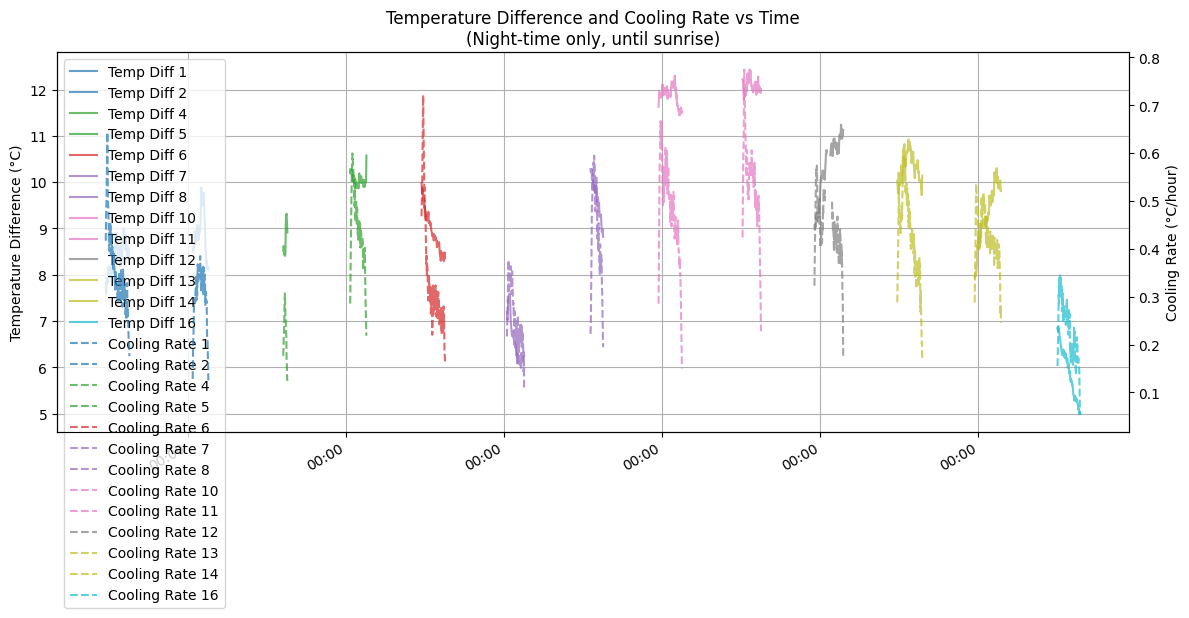

In [35]:
# Create the figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot each segment
for i, segment in enumerate(segments):
    # Get start and end dates for this segment
    start_date = segment['temp1'].index[0].date()
    end_date = segment['temp1'].index[-1].date()
    
    # Filter out data after sunrise
    mask = pd.Series(True, index=segment['temp1'].index)
    sunrise = get_sunrise(end_date) - timedelta(minutes=30)
    mask &= segment['temp1'].index.to_pydatetime() < sunrise
    
    # Apply the mask to the segment data
    filtered_temp1 = segment['temp1'][mask]
    filtered_temp2 = segment['temp2'][mask]
    
    if len(filtered_temp1) > 0:
        # Get temperature difference data
        temp_diff = filtered_temp1 - filtered_temp2
        
        # Calculate cooling rate with filtered data
        regular_time = pd.date_range(start=filtered_temp1.index[0], 
                                   end=filtered_temp1.index[-1],
                                   freq='1min')
        
        temp_interp = pd.Series(index=regular_time, 
                               data=np.interp(mdates.date2num(regular_time),
                                            mdates.date2num(filtered_temp1.index),
                                            filtered_temp1.values))
        
        # Calculate derivative and smooth it
        window = 60  # 1 hour window for smoothing
        dt = 1/60  # time step in hours
        dT_dt = np.gradient(temp_interp.values) / dt  # degrees per hour
        dT_dt_smooth = pd.Series(index=regular_time,
                                data=np.convolve(dT_dt, np.ones(window)/window, mode='same'))
        
        # Interpolate temp_diff instead of reindexing
        y_data = pd.Series(index=regular_time,
                          data=np.interp(mdates.date2num(regular_time),
                                       mdates.date2num(temp_diff.index),
                                       temp_diff.values))
        
        # Plot on both axes
        line1 = ax1.plot(regular_time, y_data, '-', color=colors[i], 
                        label=f'Temp Diff {i+1}', alpha=0.7)
        line2 = ax2.plot(regular_time, -dT_dt_smooth, '--', color=colors[i], 
                        label=f'Cooling Rate {i+1}', alpha=0.7)

# Configure axes
ax1.set_ylabel('Temperature Difference (°C)', color='black')
ax2.set_ylabel('Cooling Rate (°C/hour)', color='black')

# Configure x-axis for better time display
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set title and grid
ax1.set_title('Temperature Difference and Cooling Rate vs Time\n(Night-time only, until sunrise)')
ax1.grid(True)

plt.tight_layout()
plt.show()

In [36]:
y_data

2025-03-12 00:00:00    6.828000
2025-03-12 00:01:00    6.837067
2025-03-12 00:02:00    6.846133
2025-03-12 00:03:00    6.855200
2025-03-12 00:04:00    6.864267
                         ...   
2025-03-12 06:46:00    4.999333
2025-03-12 06:47:00    4.998667
2025-03-12 06:48:00    4.998000
2025-03-12 06:49:00    4.997333
2025-03-12 06:50:00    4.996667
Freq: min, Length: 411, dtype: float64

In [37]:
dT_dt_smooth

2025-03-12 00:00:00   -0.155267
2025-03-12 00:01:00   -0.159600
2025-03-12 00:02:00   -0.165444
2025-03-12 00:03:00   -0.171289
2025-03-12 00:04:00   -0.177133
                         ...   
2025-03-12 06:46:00   -0.076722
2025-03-12 06:47:00   -0.071144
2025-03-12 06:48:00   -0.065567
2025-03-12 06:49:00   -0.059989
2025-03-12 06:50:00   -0.054411
Freq: min, Length: 411, dtype: float64

In [38]:
temp_interp

2025-03-12 00:00:00    19.749000
2025-03-12 00:01:00    19.739644
2025-03-12 00:02:00    19.730289
2025-03-12 00:03:00    19.720933
2025-03-12 00:04:00    19.711578
                         ...    
2025-03-12 06:46:00    18.124978
2025-03-12 06:47:00    18.125956
2025-03-12 06:48:00    18.126933
2025-03-12 06:49:00    18.127911
2025-03-12 06:50:00    18.128889
Freq: min, Length: 411, dtype: float64